## Setting

In [1]:
# drive mount & setting for TaPR package
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install '/content/drive/My Drive/data/eTaPR-1.12-py3-none-any.whl'

Processing ./drive/My Drive/data/eTaPR-1.12-py3-none-any.whl


In [3]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

HOME = '/content/drive/My Drive'

In [4]:
# functions
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [5]:
# data loading
TRAIN_DATASET = sorted([x for x in Path(HOME +"/data/training/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path(HOME + "/data/testing/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path(HOME + "/data/validation/").glob("*.csv")])

TRAIN_DATASET, TEST_DATASET, VALIDATION_DATASET

([PosixPath('/content/drive/My Drive/data/training/train1.csv'),
  PosixPath('/content/drive/My Drive/data/training/train2.csv'),
  PosixPath('/content/drive/My Drive/data/training/train3.csv')],
 [PosixPath('/content/drive/My Drive/data/testing/test1.csv'),
  PosixPath('/content/drive/My Drive/data/testing/test2.csv'),
  PosixPath('/content/drive/My Drive/data/testing/test3.csv'),
  PosixPath('/content/drive/My Drive/data/testing/test4.csv')],
 [PosixPath('/content/drive/My Drive/data/validation/validation.csv')])

In [6]:
# data type to pandas DataFrame
TRAIN_DATASET = dataframe_from_csvs(TRAIN_DATASET)
TEST_DATASET = dataframe_from_csvs(TEST_DATASET)
VALIDATION_DATASET = dataframe_from_csvs(VALIDATION_DATASET)

In [8]:
# normalizing
STATE = TRAIN_DATASET.columns.drop(['time'])
TAG_MIN, TAG_MAX = TRAIN_DATASET[STATE].min(), TRAIN_DATASET[STATE].max()

def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

# time = TRAIN_DATASET['time']
train_df = normalize(TRAIN_DATASET[STATE]).ewm(alpha = 0.7).mean()
val_df = normalize(VALIDATION_DATASET[STATE]).ewm(alpha = 0.7).mean()
test_df = normalize(TEST_DATASET[STATE]).ewm(alpha = 0.7).mean()

In [9]:
def boundary_check(df):
  '''
  check dataframe
  (F, F, F) for training data set
  third should be F for others, too.  
  '''
  x = np.array(df, dtype = np.float32)
  return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

display(boundary_check(train_df))
display(boundary_check(val_df))
display(boundary_check(test_df))

(False, False, False)

(True, True, False)

(True, True, False)

## Make Datatset

In [10]:
WINDOW_SIZE = 90
WINDOW_GIVEN = 90 # autoencoder
#WINDOW_GIVEN = 89


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None, auto = False):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        self.auto = auto
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        if self.auto:
          item["answer"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        else:
          item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [11]:
# lstm, gru
# HAI_TRAIN = HaiDataset(TRAIN_DATASET['time'], train_df, stride = 10)
# HAI_VAL = HaiDataset(VALIDATOIN_DATASET['time'], val_df, attacks = VALIDATOIN_DATASET['attack'])
# HAI_TEST = HaiDataset(TEST_DATASET['time'], test_df, stride = 1)

# autoencoder
HAI_TRAIN = HaiDataset(TRAIN_DATASET['time'], train_df, stride = 10, auto = True)
HAI_VAL = HaiDataset(VALIDATION_DATASET['time'], val_df, attacks = VALIDATION_DATASET['attack'], auto = True)
HAI_TEST = HaiDataset(TEST_DATASET['time'], test_df, stride = 1, auto = True)


# of valid windows: 92134



# of valid windows: 43112



# of valid windows: 358448


In [12]:
display(HAI_TRAIN[0])
display(HAI_VAL[0])
display(HAI_TEST[0])
HAI_TRAIN[0]['answer'].shape[1] == HAI_VAL[0]['answer'].shape[1]

{'answer': tensor([[0.3790, 0.0000, 0.0000,  ..., 0.2650, 1.0000, 0.5673],
         [0.3786, 0.0000, 0.0000,  ..., 0.2538, 1.0000, 0.5206],
         [0.3785, 0.0000, 0.0000,  ..., 0.2547, 1.0000, 0.4806],
         ...,
         [0.3737, 0.0000, 0.0000,  ..., 0.4405, 1.0000, 0.5314],
         [0.3739, 0.0000, 0.0000,  ..., 0.4504, 1.0000, 0.5422],
         [0.3740, 0.0000, 0.0000,  ..., 0.4581, 1.0000, 0.5360]]),
 'given': tensor([[0.3790, 0.0000, 0.0000,  ..., 0.2650, 1.0000, 0.5673],
         [0.3786, 0.0000, 0.0000,  ..., 0.2538, 1.0000, 0.5206],
         [0.3785, 0.0000, 0.0000,  ..., 0.2547, 1.0000, 0.4806],
         ...,
         [0.3737, 0.0000, 0.0000,  ..., 0.4405, 1.0000, 0.5314],
         [0.3739, 0.0000, 0.0000,  ..., 0.4504, 1.0000, 0.5422],
         [0.3740, 0.0000, 0.0000,  ..., 0.4581, 1.0000, 0.5360]]),
 'ts': '2020-07-11 00:01:29'}

{'answer': tensor([[0.4516, 0.0000, 0.0000,  ..., 0.5798, 0.5271, 0.4014],
         [0.4523, 0.0000, 0.0000,  ..., 0.5799, 0.5271, 0.3414],
         [0.4522, 0.0000, 0.0000,  ..., 0.5891, 0.5271, 0.3639],
         ...,
         [0.5258, 0.0000, 0.0000,  ..., 0.3157, 0.5271, 0.4189],
         [0.5254, 0.0000, 0.0000,  ..., 0.3109, 0.5271, 0.4980],
         [0.5266, 0.0000, 0.0000,  ..., 0.3143, 0.5271, 0.5783]]),
 'attack': 0.0,
 'given': tensor([[0.4516, 0.0000, 0.0000,  ..., 0.5798, 0.5271, 0.4014],
         [0.4523, 0.0000, 0.0000,  ..., 0.5799, 0.5271, 0.3414],
         [0.4522, 0.0000, 0.0000,  ..., 0.5891, 0.5271, 0.3639],
         ...,
         [0.5258, 0.0000, 0.0000,  ..., 0.3157, 0.5271, 0.4189],
         [0.5254, 0.0000, 0.0000,  ..., 0.3109, 0.5271, 0.4980],
         [0.5266, 0.0000, 0.0000,  ..., 0.3143, 0.5271, 0.5783]]),
 'ts': '2020-07-07 15:01:29'}

{'answer': tensor([[0.2737, 0.0000, 0.0000,  ..., 0.2004, 0.2616, 0.7147],
         [0.2737, 0.0000, 0.0000,  ..., 0.1988, 0.2616, 0.6600],
         [0.2730, 0.0000, 0.0000,  ..., 0.1973, 0.2616, 0.6482],
         ...,
         [0.2490, 0.0000, 0.0000,  ..., 0.5522, 0.2616, 0.5145],
         [0.2501, 0.0000, 0.0000,  ..., 0.5526, 0.2616, 0.5802],
         [0.2507, 0.0000, 0.0000,  ..., 0.5515, 0.2616, 0.6408]]),
 'given': tensor([[0.2737, 0.0000, 0.0000,  ..., 0.2004, 0.2616, 0.7147],
         [0.2737, 0.0000, 0.0000,  ..., 0.1988, 0.2616, 0.6600],
         [0.2730, 0.0000, 0.0000,  ..., 0.1973, 0.2616, 0.6482],
         ...,
         [0.2490, 0.0000, 0.0000,  ..., 0.5522, 0.2616, 0.5145],
         [0.2501, 0.0000, 0.0000,  ..., 0.5526, 0.2616, 0.5802],
         [0.2507, 0.0000, 0.0000,  ..., 0.5515, 0.2616, 0.6408]]),
 'ts': '2020-07-09 15:01:29'}

True

## Model

### Setting

In [13]:
#constants
N_HIDDENS = 100
N_LAYERS = 3
BATCH_SIZE = 512

In [21]:
#train function
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    #loss_fn = torch.nn.L1Loss() #mae
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

### stacked RNN

In [ ]:
#definitions of models

class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return x[0] + out

class StackedLSTM(torch.nn.Module):
  def __init__(self, n_tags):
    super().__init__()
    self.lstm = torch.nn.LSTM(
        input_size = n_tags,
        hidden_size = N_HIDDENS,
        num_layers = N_LAYERS,
        bidirectional = True,
        dropout = 0
    )
    self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)
    self.activation = torch.nn.ReLU() #added

  def forward(self, x):
    x = x.transpose(0, 1)
    self.lstm.flatten_parameters()
    outs, _ = self.lstm(x)
    out = self.fc(outs[-1])
    return self.activation(x[0] + out) #skip connection

### AutoEncoder

In [18]:
class TimeDistributed(torch.nn.Module):
  def __init__(self, module, batch_first = False):
    super().__init__()
    self.module = module
    self.batch_first = batch_first # shape of x

  def forward(self, x):
    if len(x.size()) <= 2:
      return self.module(x)
    y = self.module(x.contiguous().view(-1, x.size(-1)))
    if self.batch_first:
      y = y.contiguous().view(x.size(0), -1, y.size(-1))
    else:
      y = y.contiguous().view(-1, x.size(1), y.size(-1))
    return y #shape : (batch, seq, features)

class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim = 64):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.seq_len = seq_len
    self.n_features = n_features
    self.rnn = torch.nn.GRU(
        input_size=self.n_features,
        hidden_size=self.embedding_dim //2,
        num_layers=3,
        bidirectional=True,
        batch_first = True
    )

  def forward(self, x):
    x, _ = self.rnn(x)
    return x[:, -1, :] # get last sample -> shape of (seq len, 1, embedding_dim)

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.seq_len = seq_len
    self.n_features = n_features
    self.rnn = torch.nn.GRU(
        input_size = self.embedding_dim,
        hidden_size = self.embedding_dim//2,
        num_layers = 4,
        bidirectional = True,
        batch_first = True
    )
    self.output_layer = torch.nn.Linear(self.embedding_dim, self.n_features)
    self.timedist = TimeDistributed(self.output_layer)

  def forward(self, x):
    x = x.reshape(-1, 1, self.embedding_dim).repeat(1, self.seq_len, 1)
    x, _ = self.rnn(x)
    return self.timedist(x)

class RecurrentAutoencoder(torch.nn.Module): # embedding dim should be even
  def __init__(self, seq_len, n_features, embedding_dim):
    super().__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim)
    self.decoder = Decoder(seq_len, n_features, embedding_dim)
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

## Train !

In [19]:
MODEL = RecurrentAutoencoder(seq_len = 90, n_features = 79, embedding_dim = 100)
# MODEL = StackedGRU(n_tags = 79)
# MODEL = StackedLSTM(n_tags = 79)

MODEL.cuda()

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn): GRU(79, 50, num_layers=3, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (rnn): GRU(100, 50, num_layers=4, batch_first=True, bidirectional=True)
    (output_layer): Linear(in_features=100, out_features=79, bias=True)
    (timedist): TimeDistributed(
      (module): Linear(in_features=100, out_features=79, bias=True)
    )
  )
)

In [23]:
%%time
BATCH_SIZE = 256 # change!
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_TRAIN, MODEL, BATCH_SIZE, 50) # change : epoch


CPU times: user 24min 4s, sys: 43.4 s, total: 24min 47s
Wall time: 24min 56s


In [24]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

(0.3813759348122403, 49)

In [25]:
with open("gru_ae.pt", "wb") as f:
  torch.save(
            {
          "state": BEST_MODEL["state"],
          "best_epoch": BEST_MODEL["epoch"],
          "loss_history": LOSS_HISTORY,
      },
      f,
  )

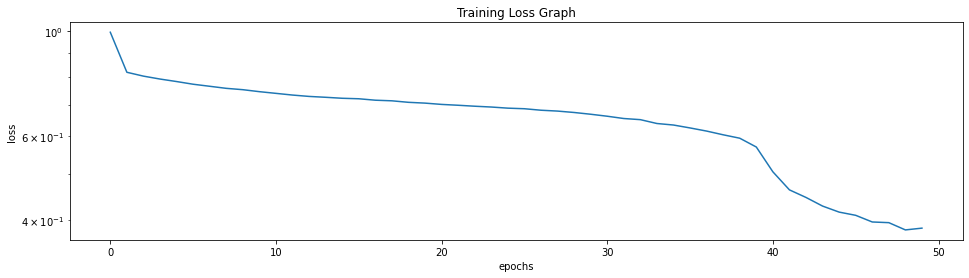

In [26]:
# check loss
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(LOSS_HISTORY)
plt.show()

## Validation

In [27]:
# load model
with open("/content/gru_ae.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

<All keys matched successfully>

In [28]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 6 * piece))
    # plt.ylim(0.01, 0.1)
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [29]:
%%time
BATCH_SIZE = 512
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_VAL, MODEL, BATCH_SIZE)

CPU times: user 4.89 s, sys: 1.37 s, total: 6.26 s
Wall time: 6.28 s


In [30]:
CHECK_DIST.shape #(43112, 79) / (43112, 90, 79) for autoencoder

(43112, 90, 79)

In [33]:
#ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
ANOMALY_SCORE = np.mean(np.mean(CHECK_DIST, axis=1), axis = 1) #autoencoder
ANOMALY_SCORE.shape #(43112,)

(43112,)

In [32]:
def new_anomaly(dist):
  prev = dist[0]
  anomaly = []
  for e in dist:
    anomaly.append(np.abs(prev - e))
    prev = e
  return np.array(anomaly)

ANOMALY_SCORE = new_anomaly(ANOMALY_SCORE)

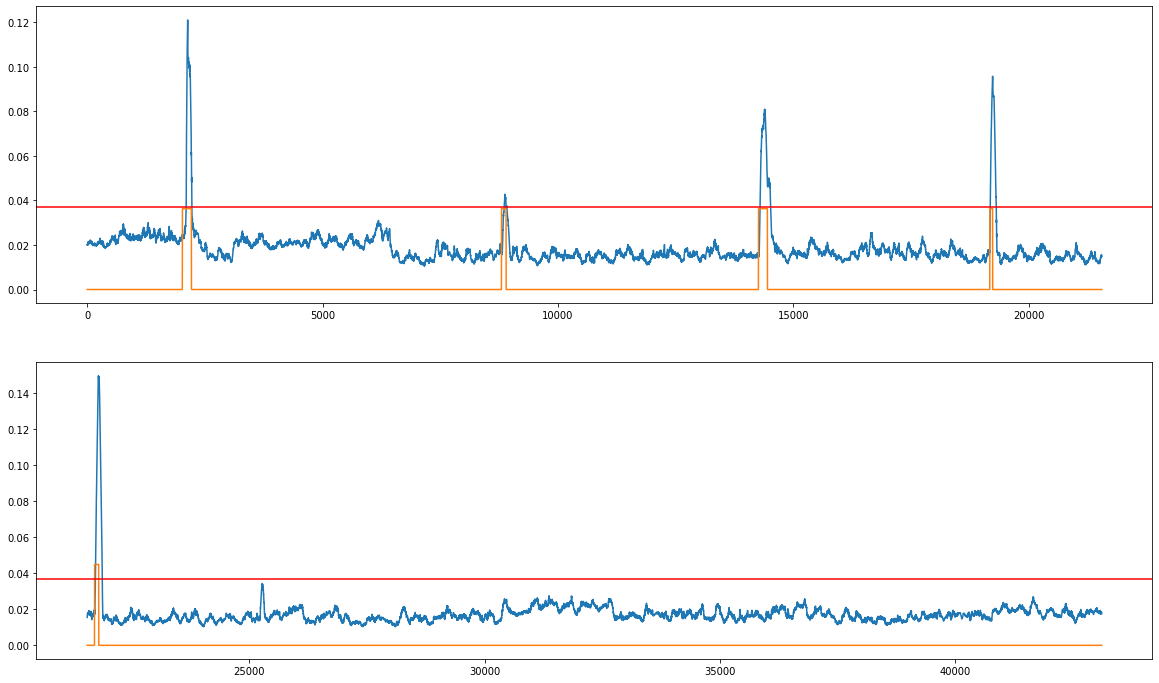

In [37]:
THRESHOLD = 0.037 # change !!
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

In [38]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
display(LABELS, LABELS.shape) #(43112,)
LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DATASET['time']))
print(LABELS.shape)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

(43112,)

(43201,)


In [39]:
ATTACK_LABELS = np.squeeze(np.array(VALIDATION_DATASET['attack']))
# ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), 0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (43201,))

In [40]:
ATTACK_LABELS.shape[0] == LABELS.shape[0]

True

### Get score

In [41]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.949 (TaP: 0.991, TaR: 0.911)
# of detected anomalies: 5
Detected anomalies: ['1', '2', '3', '4', '5']


## Test

In [ ]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_TEST, MODEL, BATCH_SIZE)

In [ ]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
ANOMALY_SCORE.shape

In [ ]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [ ]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

In [ ]:
submission = pd.read_csv(HOME + '/data/sample_submission.csv')
submission.index = submission['time']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

In [ ]:
submission.to_csv('autoencoder.csv', index=False)